# Second part
Since we construct model directly, based on the train and test data, and we have tried adding the regularisation terms, changing the loss function in a balanced form, but the performance of our models still can be improved. One can reconsider the features we extracted, or the approach of the whole process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df = train_df.drop('baseFare', axis=1)
test_df = test_df.drop('baseFare', axis=1)

In [4]:
target_var = train_df[['totalFare']]
target_var.sort_values(by='totalFare', ascending=False)

,totalFare
14281,4194.20
30936,4194.20
58166,3209.90
60489,2464.90
43604,2249.90
...,...
57199,26.89
47420,26.89
47421,26.89
32605,26.89


### Change to a classification model

From the EDA, density plot of the target variables, one can find the distribution of prices is skewed to the right, and the left part seems to follow a normal distribution, indicating that we can build two models, one for the small prices (left part), the other for the large prices.

/var/folders/_j/x8h1yttn1s76k8f3bvjm72rw0000gn/T/ipykernel_22984/2069056689.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax1)


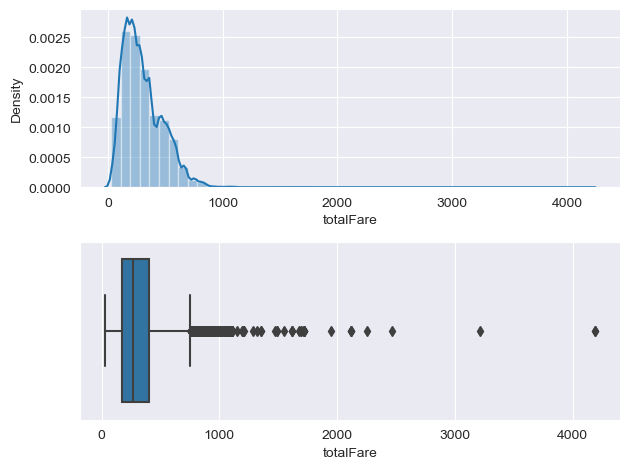

In [5]:
def plot_density(df, col):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    sns.distplot(df[col], ax=ax1)
    sns.boxplot(x=df[col], ax=ax2)
    plt.tight_layout()


plot_density(target_var, 'totalFare')

In [6]:
def label_outliers_zscore(col):
    z_scores = np.abs((col - col.mean()) / col.std())
    return np.array([1 if z > 3 else 0 for z in z_scores])


target_var['isOutlier'] = label_outliers_zscore(target_var['totalFare'])
target_var

/var/folders/_j/x8h1yttn1s76k8f3bvjm72rw0000gn/T/ipykernel_22984/3113253553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_var['isOutlier'] = label_outliers_zscore(target_var['totalFare'])


,totalFare,isOutlier
0,176.71,0
1,148.90,0
2,112.89,0
3,552.01,0
4,538.90,0
...,...,...
71026,93.90,0
71027,409.20,0
71028,274.20,0
71029,298.20,0


### Lack of evidence to do that.

Recall our approach, fist of all we need to detect what is the large price. We consider z-score outlier detection to label the data, but we find the large price and small price are highly imbalanced. Moreover, when a new test data come in, we dont know its label. So if we label the test data as well, then the future information may be used. Hence, due to this requirement and problem, we shall consider another approach: Unsupervised learning.

In [7]:
target_var.groupby('isOutlier').count()

,totalFare
isOutlier,
0,70577
1,454


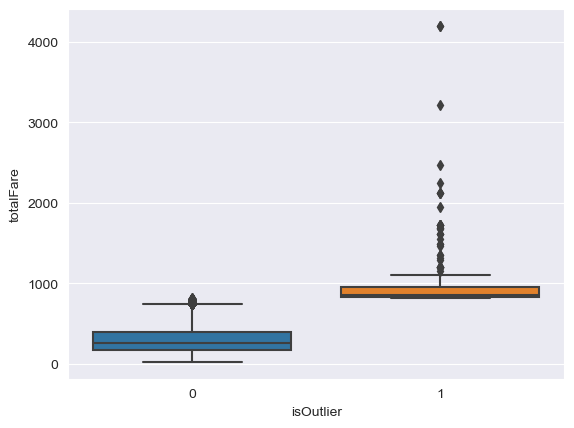

In [8]:
sns.boxplot(target_var, y='totalFare', x='isOutlier')
plt.show()

## Discussion on this approach

If we make it as a binary classification problem, then it would be not appropriate, since two classes are highly imbalanced, may leading to the low precision.

Hence we may apply outlier detection model.

But the problem is, we dont know the future data, it may be abnormal again.

A proper way is adding weights on that abnormal data

In [9]:
def find_noise_var(vector):
    mean = np.mean(vector)
    new_vector = vector - mean
    sum_squares = np.sum(new_vector ** 2)
    sigma = np.sqrt(sum_squares / (len(vector) - 1))
    return sigma

In [10]:
find_noise_var(target_var['totalFare'] * (1 - target_var['isOutlier']))

162.65161131712352

In [11]:
y_train = train_df[['totalFare']]
x_train = train_df.drop('totalFare', axis=1)
y_test = test_df[['totalFare']]
x_test = test_df.drop('totalFare', axis=1)

In [12]:
xgb_bad = pd.read_csv('data/xgb_bad_learn.csv')
xgb_bad

,Unnamed: 0,true,pred
0,34,367.20,421.16790
1,76,468.91,375.11850
2,77,485.19,356.18057
3,97,748.20,682.17530
4,129,599.20,464.07758
...,...,...,...
3547,70915,548.20,449.69067
3548,70917,511.70,454.05765
3549,70971,709.19,631.46063
3550,70983,488.90,427.41030


<AxesSubplot: xlabel='true'>

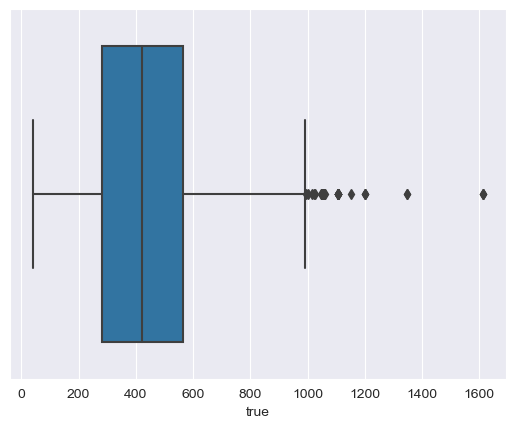

In [13]:
sns.boxplot(data=xgb_bad, x='true')

In [14]:
x_train_negative = x_train.drop(xgb_bad['Unnamed: 0'])

In [15]:
x_train_negative

,days_to_depart,flight_day_of_week,isDeparture_time_6to18,isArriving_time_11to24,stops,travelDuration_h,elapsedDays,isBasicEconomy,isNonStop,seatsRemaining,...,class_first,class_first+coach,class_first+coach+first,class_premium coach,class_premium coach+coach,destinationAirport_ATL,destinationAirport_DFW,destinationAirport_JFK,destinationAirport_LAX,destinationAirport_ORD
0,39.0,5.0,1.0,1.0,1.0,8.233333,0.0,1.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,21.0,1.0,1.0,1.0,0.0,3.100000,0.0,1.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,14.0,1.0,1.0,0.0,0.0,2.316667,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,21.0,1.0,1.0,1.0,2.0,10.150000,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,27.0,0.0,1.0,0.0,0.0,5.416667,1.0,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,27.0,0.0,1.0,1.0,0.0,2.566667,0.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71027,51.0,3.0,1.0,1.0,1.0,8.116667,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71028,23.0,3.0,1.0,1.0,1.0,7.133333,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
71029,23.0,3.0,1.0,1.0,1.0,4.566667,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
from Modeling_reg import OutlierDetection_models

OD_models = OutlierDetection_models(x_train_negative, x_test, encoding_dim=64)

In [17]:
autoencoder_model = OD_models.auto_encoder()

2023-04-18 19:18:55.517946: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-18 19:18:55.519944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 19:18:55.636673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
2109/2109 [==============================] - 1s 573us/step - loss: 59777.4050
Epoch 2/50
2109/2109 [==============================] - 1s 557us/step - loss: 55756.4378
Epoch 3/50
2109/2109 [==============================] - 1s 554us/step - loss: 51892.2698
Epoch 4/50
2109/2109 [==============================] - 1s 553us/step - loss: 48159.5593
Epoch 5/50
2109/2109 [==============================] - 1s 545us/step - loss: 44561.6655
Epoch 6/50
2109/2109 [==============================] - 1s 548us/step - loss: 40861.0142
Epoch 7/50
2109/2109 [==============================] - 1s 552us/step - loss: 38132.6095
Epoch 8/50
2109/2109 [==============================] - 1s 549us/step - loss: 35009.6544
Epoch 9/50
2109/2109 [==============================] - 1s 552us/step - loss: 32317.4706
Epoch 10/50
2109/2109 [==============================] - 1s 546us/step - loss: 29579.5770
Epoch 11/50
2109/2109 [==============================] - 1s 545us/step - loss: 27041.0165
Epoch 12/50
2109/21

In [22]:
def isOutlier(true, pred, threshold_pct):
    mse = np.mean(np.power(true - pred, 2), axis=1)
    threshold = np.percentile(mse, threshold_pct)
    # return index where mse>threshold
    outliers_array = np.where(mse > threshold)[0]
    return outliers_array

In [23]:
aec_train_outliers = OD_models.aec_train_outliers
aec_test_outliers = OD_models.aec_test_outliers

In [24]:
x_train_pred = autoencoder_model.predict(x_train)

In [25]:
x_train_aec_out = isOutlier(x_train, x_train_pred, 99)

In [26]:
train_new = train_df.drop(x_train_aec_out, axis=0)
test_new = test_df.drop(aec_test_outliers, axis=0)

In [27]:
train_new

,days_to_depart,flight_day_of_week,isDeparture_time_6to18,isArriving_time_11to24,stops,travelDuration_h,elapsedDays,isBasicEconomy,isNonStop,seatsRemaining,...,class_first+coach,class_first+coach+first,class_premium coach,class_premium coach+coach,destinationAirport_ATL,destinationAirport_DFW,destinationAirport_JFK,destinationAirport_LAX,destinationAirport_ORD,totalFare
0,39.0,5.0,1.0,1.0,1.0,8.233333,0.0,1.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,176.71
1,21.0,1.0,1.0,1.0,0.0,3.100000,0.0,1.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,148.90
2,14.0,1.0,1.0,0.0,0.0,2.316667,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,112.89
3,21.0,1.0,1.0,1.0,2.0,10.150000,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,552.01
4,27.0,0.0,1.0,0.0,0.0,5.416667,1.0,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,538.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,27.0,0.0,1.0,1.0,0.0,2.566667,0.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,93.90
71027,51.0,3.0,1.0,1.0,1.0,8.116667,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,409.20
71028,23.0,3.0,1.0,1.0,1.0,7.133333,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,274.20
71029,23.0,3.0,1.0,1.0,1.0,4.566667,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,298.20


In [30]:
train_neg = train_df.drop(xgb_bad['Unnamed: 0'])
train_new = train_neg

In [31]:
# train_new.to_csv('data/train_new_aec.csv',index=False)
# test_new.to_csv('data/test_new_aec.csv',index=False)

In [32]:
from Modeling_reg import Regression_models

y_train_new = train_new[['totalFare']]
x_train_new = train_new.drop('totalFare', axis=1)
y_test_new = test_new[['totalFare']]
x_test_new = test_new.drop('totalFare', axis=1)
Reg_models = Regression_models(x_train_new, y_train_new, x_test_new, y_test_new, standardlise=True)

Best parameters:  {'n_estimators': 200, 'max_depth': 8, 'alpha': 1}
XGBR train R_sq:  0.9659138208230037
XGBR train MSE:  943.9286059362643
XGBR test R_sq:  0.864754890398054
XGBR test MSE:  4337.027052026648


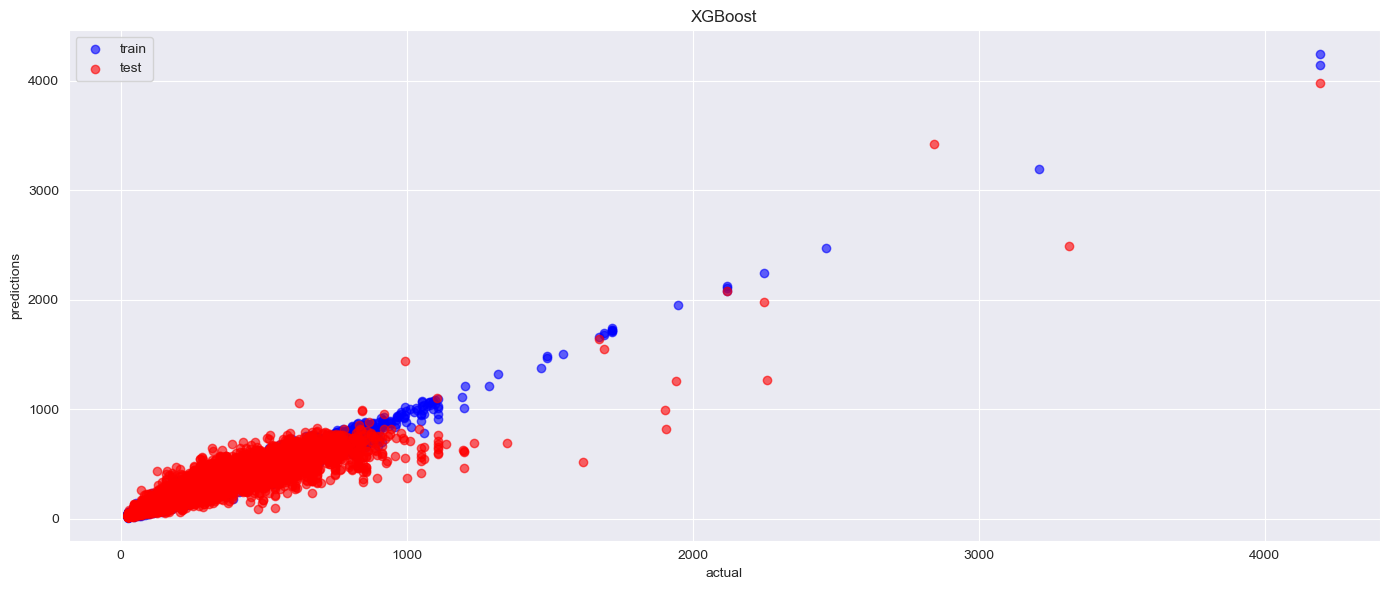

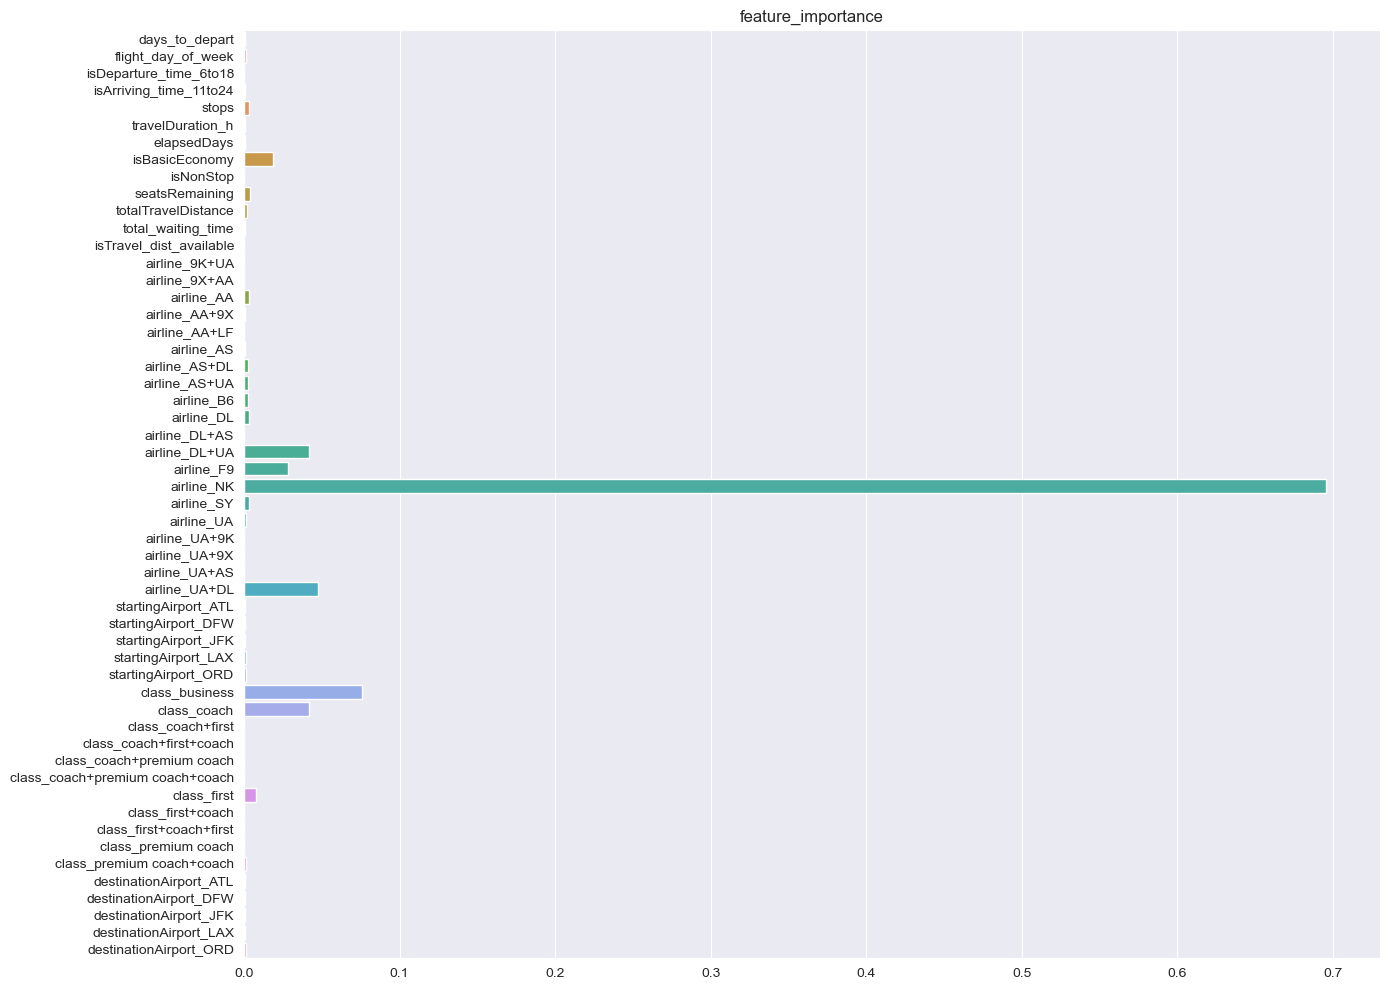

In [33]:
# XGBoost Best Parameters: {'max_depth': 8, 'n_estimators': 200} alpha = 1, by GridsearchCV
xgb_model = Reg_models.XGBR(search=False, best_depth_input=8, best_Nestimators=200, show_avsp=True,
                            show_features_imp=True, search_L1_alpha=False, L1_alpha=1)

In [35]:
train_out = train_df.iloc[xgb_bad['Unnamed: 0']]
test_out = test_df.iloc[aec_test_outliers]
y_train_new_out = train_out[['totalFare']]
x_train_new_out = train_out.drop('totalFare', axis=1)
y_test_new_out = test_out[['totalFare']]
x_test_new_out = test_out.drop('totalFare', axis=1)

Best parameters:  {'n_estimators': 10, 'max_depth': 5, 'alpha': None}
XGBR train R_sq:  0.43844846759847145
XGBR train MSE:  22931.800162580825
XGBR test R_sq:  0.2650521798307002
XGBR test MSE:  14194.649773792264


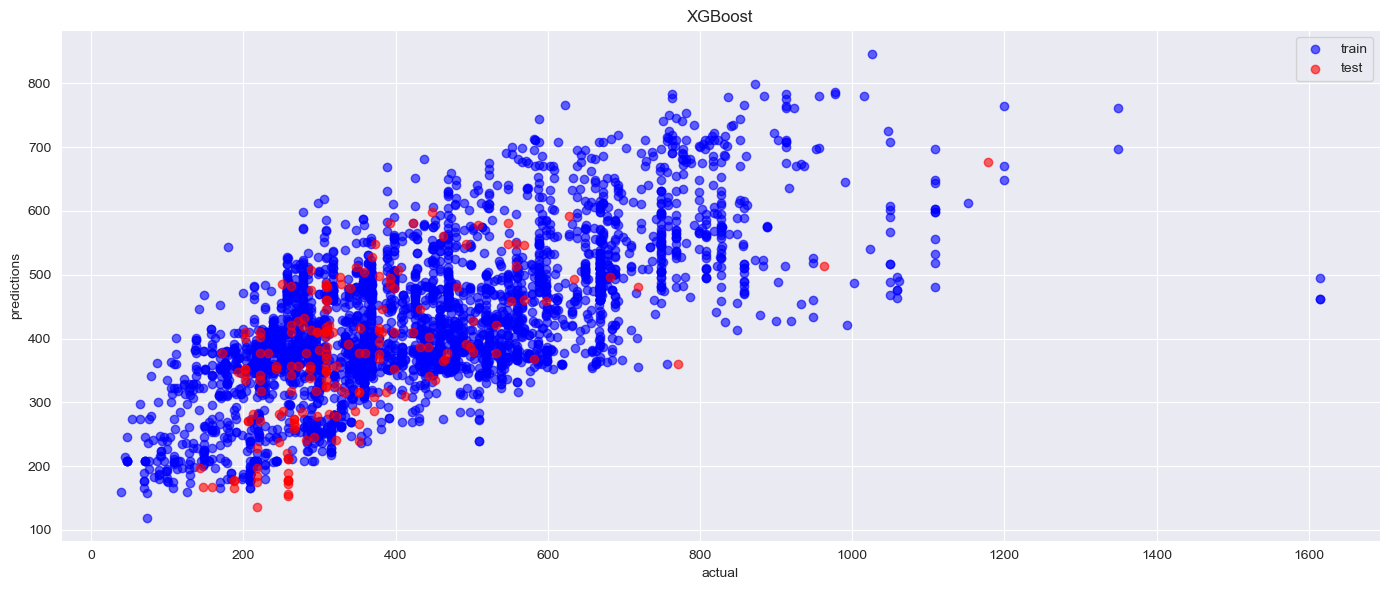

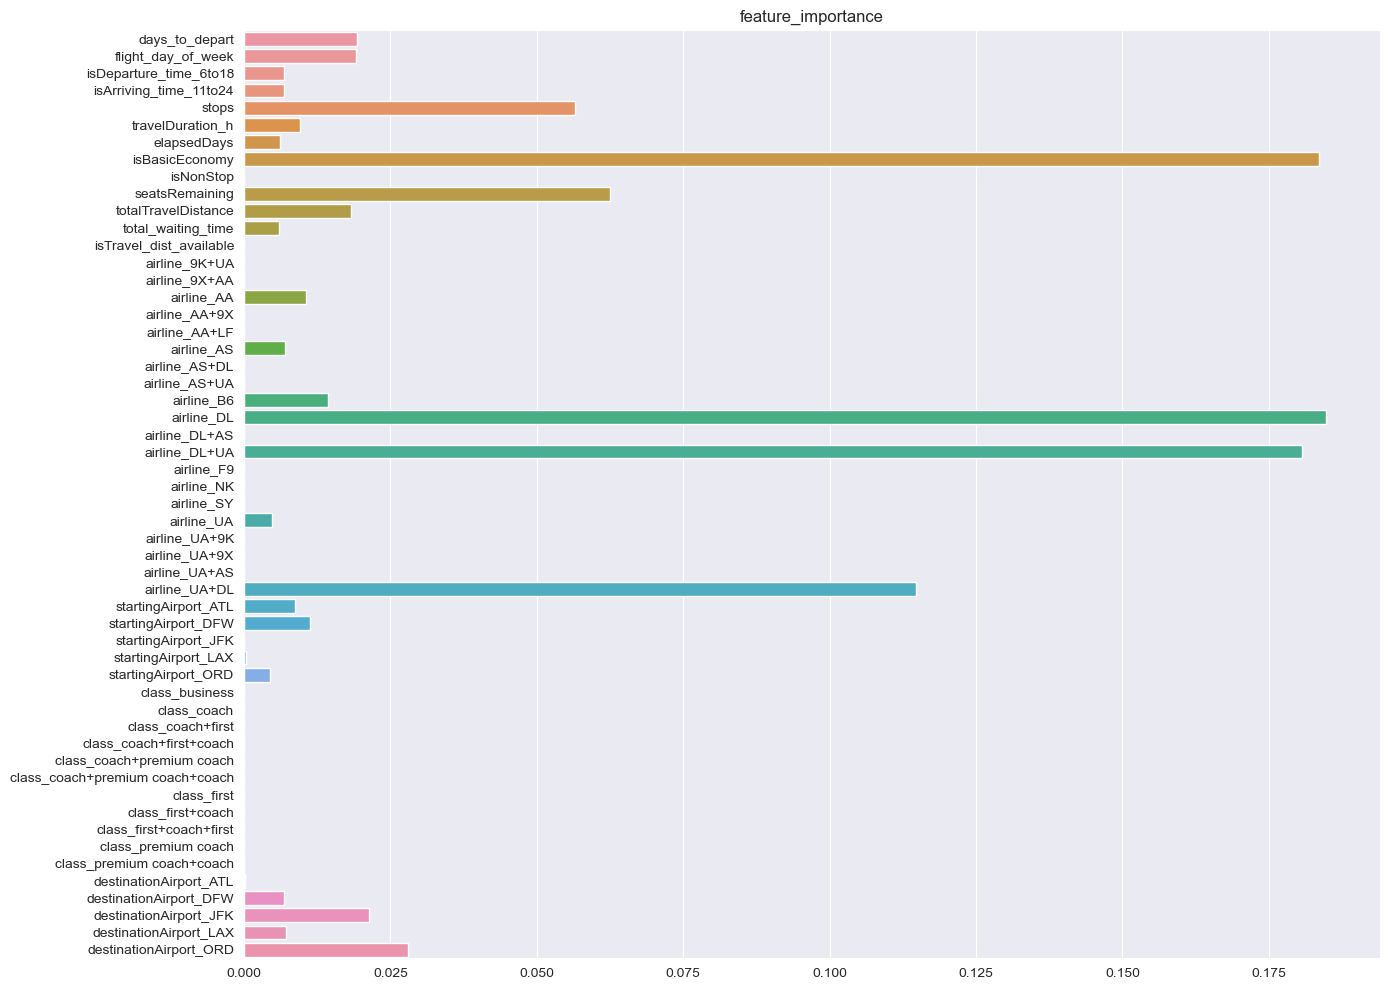

In [39]:
Reg_models_out = Regression_models(x_train_new_out, y_train_new_out, x_test_new_out, y_test_new_out, standardlise=True)
#XGBoost Best Parameters: {'max_depth': 8, 'n_estimators': 200}
xgb_model_out = Reg_models_out.XGBR(search=False, best_depth_input=5, best_Nestimators=10, show_avsp=True,
                                    show_features_imp=True, search_L1_alpha=False, L1_alpha=None)

In [40]:
# train_out.to_csv('data/train_abnormal.csv',index=False)
# test_out.to_csv('data/test_abnormal.csv',index=False)

In [78]:
normal_model_train = Reg_models.xgb_train_info_df
normal_model_test = Reg_models.xgb_test_info_df

In [79]:
abnormal_model_train = Reg_models_out.xgb_train_info_df
abnormal_model_test = Reg_models_out.xgb_test_info_df

In [87]:
all_train_info = pd.concat([normal_model_train, abnormal_model_train], axis=0)
all_test_info = pd.concat([normal_model_test, abnormal_model_test], axis=0)
all_train_info

,true,pred
0,176.71,150.483749
1,148.90,159.301834
2,112.89,100.910660
3,552.01,557.243225
4,538.90,450.512115
...,...,...
706,408.20,370.622711
707,332.20,293.258911
708,218.21,205.993912
709,147.20,175.696747


In [88]:
from sklearn.metrics import mean_squared_error, r2_score
r_sq_tr = r2_score(all_train_info['true'], all_train_info['pred'])
mse_tr = mean_squared_error(all_train_info['true'], all_train_info['pred'])
print('train R_square: ', r_sq_tr)
print('train MSE: ', mse_tr)
r_sq = r2_score(all_test_info['true'], all_test_info['pred'])
mse_te = mean_squared_error(all_test_info['true'], all_test_info['pred'])
print('test R_square: ', r_sq)
print('test MSE: ', mse_te)

train R_square:  0.946395844027947
train MSE:  1573.0435660757087
test R_square:  0.8699042065725288
test MSE:  4157.343778688602
